<a href="https://colab.research.google.com/github/gabrieldimas/machine-learning-study-2023/blob/main/Week9/week9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Praktikum 1

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I watched \'Ice Age\'in the movie theater and I liked the movie. Spite of the fact that \'Ice Age\'has many flaws and scientific errors,like humans,sabers,dinosaurs and mammoths living at the same period, and even the location of where the story passes(looks North America,but has some characteristics from Iceland for example) we can have fun even so.(unless you are very severe!) <br /><br />The planet is entering an ICE AGE, and many animals are immigrating to the south where is warmer. Sid is a stupid Sloth that is left behind by his own family, that can\'t stand him any longer.Walking in his way, he meets Manfred,or how he calls \'\' Manny\'\' a moody mammoth who does not care about extinction or immigration and is going to the north. Worried that he can easily be captured, Sid decides to follow Manfred, and in the middle of their journey, they found a human mother with her baby. The mother dies but Manfred and Sid decides to take him and return the baby for the humans. Di

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [13]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 10, 284,   1, ...,   0,   0,   0],
       [ 45,  23,   4, ...,   0,   0,   0],
       [  1,   1, 442, ...,   0,   0,   0]])

In [14]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I watched \'Ice Age\'in the movie theater and I liked the movie. Spite of the fact that \'Ice Age\'has many flaws and scientific errors,like humans,sabers,dinosaurs and mammoths living at the same period, and even the location of where the story passes(looks North America,but has some characteristics from Iceland for example) we can have fun even so.(unless you are very severe!) <br /><br />The planet is entering an ICE AGE, and many animals are immigrating to the south where is warmer. Sid is a stupid Sloth that is left behind by his own family, that can\'t stand him any longer.Walking in his way, he meets Manfred,or how he calls \'\' Manny\'\' a moody mammoth who does not care about extinction or immigration and is going to the north. Worried that he can easily be captured, Sid decides to follow Manfred, and in the middle of their journey, they found a human mother with her baby. The mother dies but Manfred and Sid decides to take him and return the baby for the humans. 

In [15]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [17]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [18]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-0.00310168]


In [19]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 487ms/step
[-0.00310168]


In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 690s 2s/step - loss: 0.6473 - accuracy: 0.5586 - val_loss: 0.4748 - val_accuracy: 0.7573
Epoch 2/10
391/391 [==============================] - 684s 2s/step - loss: 0.4075 - accuracy: 0.8090 - val_loss: 0.3795 - val_accuracy: 0.8370
Epoch 3/10
391/391 [==============================] - 702s 2s/step - loss: 0.3499 - accuracy: 0.8464 - val_loss: 0.3469 - val_accuracy: 0.8427
Epoch 4/10
391/391 [==============================] - 683s 2s/step - loss: 0.3255 - accuracy: 0.8590 - val_loss: 0.3379 - val_accuracy: 0.8536
Epoch 5/10
391/391 [==============================] - 688s 2s/step - loss: 0.3144 - accuracy: 0.8668 - val_loss: 0.3416 - val_accuracy: 0.8411
Epoch 6/10
391/391 [==============================] - 686s 2s/step - loss: 0.3067 - accuracy: 0.8678 - val_loss: 0.3242 - val_accuracy: 0.8505
Epoch 7/10
391/391 [==============================] - 693s 2s/step - loss: 0.3014 - accuracy: 0.8718 - val_loss: 0.3242 - val_accuracy: 0.8568

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 159s 406ms/step - loss: 0.3191 - accuracy: 0.8520
Test Loss: 0.319088876247406
Test Accuracy: 0.8519999980926514


(0.0, 0.6648980811238289)

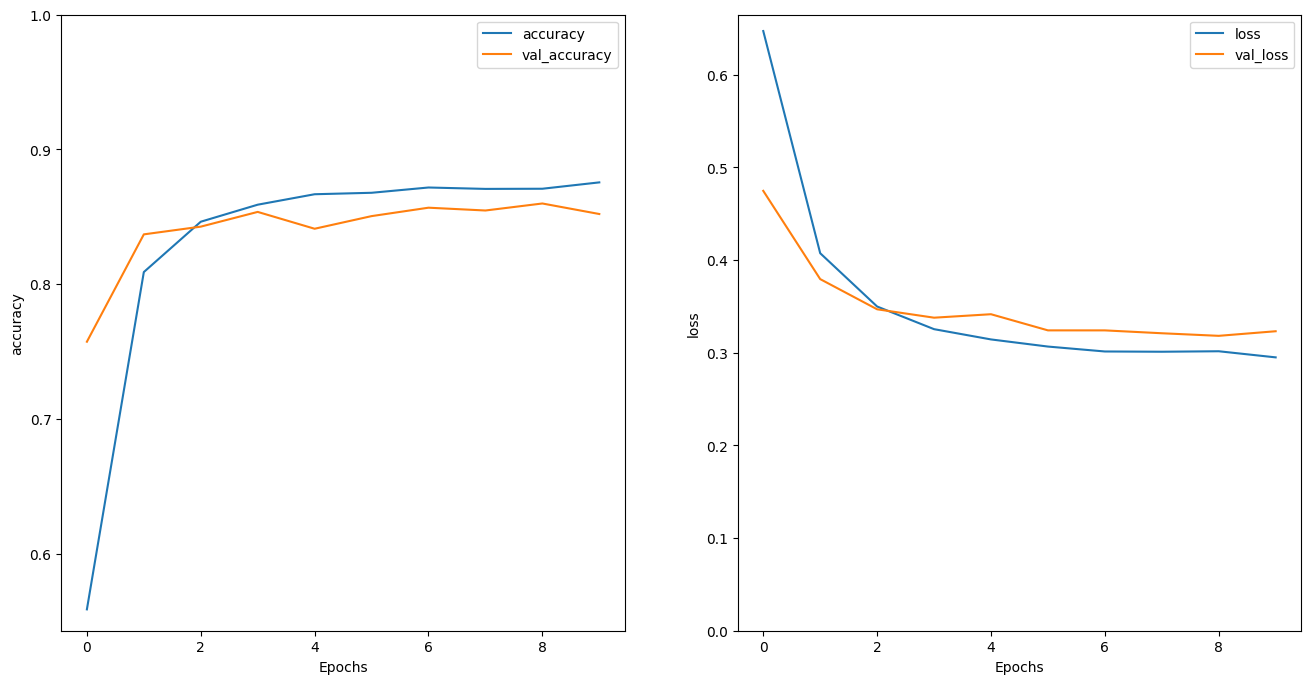

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [26]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [28]:
model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  optimizer=tf.keras.optimizers.Adam(1e-4),
  metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
 validation_data=test_dataset,
 validation_steps=30)